In [1]:
%load_ext autoreload

# Anomaly Detection Refinements

## IPOC measurement lengths

In [2]:
%matplotlib inline
import os, sys
import numpy as np
import pandas as pd
from IPython.display import display
sys.path.append(os.path.abspath(os.path.join('..')))

import plot.features, plot.anomalies
from plot import pyplot as plt
from database.CERNMongoClient import CERNMongoClient
from anomaly_detection import GMM
from feature_extraction import feature_extraction, preprocessing, PCA

db = CERNMongoClient()

# auto-load changes in imported modules
%autoreload 2

In [3]:
df = db.query("MKI.UA23.IPOC.AB1:T_LENGTH")
index = df.index.round("S")
df["timestamps"] = index

Fetching data for pattern MKI.UA23.IPOC.AB1:T_LENGTH from 2016-04-16 00:00:00.000000 to 2016-09-14 00:00:00.000000
Fetching data for MKI.UA23.IPOC.AB1:T_LENGTH


Repeated experiment from last week.
IPOC clusters are ended when the time between 2 IPOC measurements exceeds 30 minutes. Not counting clusters of length 1 (isolated IPOC measurements).

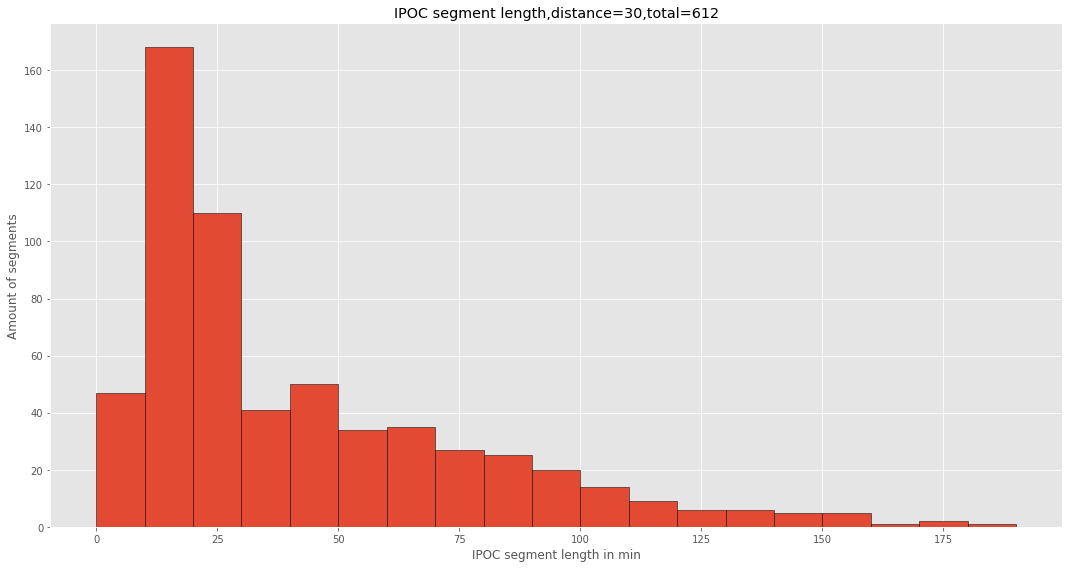

In [4]:
plot.features.ipoc_segment_length_histogram(df)

## Anomaly detection beam 1

For the following experiments, all data is used of beam 1. The IPOC timestamps of beam 1 and 2 are not in sync. If they were, it would take to long to process on laptop. Sliding window size is still 10 minutes (needs to be adjusted to 30).

The dataframe is obtained by running `build_features.py`

In [17]:
df = feature_extraction.load_features_from_file(beam=1)
dfs = preprocessing.scale_robust(df)

display(dfs.shape, dfs.describe())

Loading file '/home/n/master-thesis/src/../data-cern/features_b1_'.
File not found, loading '/home/n/master-thesis/src/../data-cern/features_b1_sw-30min_2018-02-23.csv' instead.


(46090, 88)

MKI.UA23.IPOC.CB1:T_LENGTH  MKI.UA23.IPOC.AB1:T_LENGTH  \
count                46090.000000                46090.000000   
mean                     0.896352                    0.929468   
std                      4.189893                    4.418192   
min                    -42.135794                   -0.867274   
25%                     -0.002550                   -0.001997   
50%                      0.000000                    0.000000   
75%                      0.997450                    0.998003   
max                     57.370476                   57.102529   

       MKI.UA23.IPOC.AB1:E_KICK  MKI.UA23.IPOC.DB1:E_KICK  \
count              46090.000000              46090.000000   
mean                   0.019731                  0.019710   
std                    0.478232                  0.478251   
min                   -0.523308                 -0.523392   
25%                   -0.515076                 -0.515126   
50%                    0.000000                  0.000000   
75%                    0.484924                  0.484874   
max                    0.710525                  0.710531   

       MKI.UA23.IPOC.AB1:T_FALLTIME  MKI.UA23.IPOC.DB1:T_FALLTIME  \
count                  46090.000000                  46090.000000   
mean                      -0.431896                     -3.343751   
std                      182.688320                    493.942922   
min                   -12073.590476                 -12208.028846   
25%                       -0.352381                     -0.326923   
50%                        0.000000                      0.000000   
75%                        0.647619                      0.673077   
max                    11815.638095                  11946.355769   

       MKI.UA23.IPOC.AB1:T_START_TH  MKI.UA23.IPOC.CB1:E_KICK  \
count                  46090.000000              46090.000000   
mean                     161.830792                  0.019710   
std                     1311.170873                  0.478251   
min                   -13223.800000                 -0.523392   
25%                       -0.400000                 -0.515126   
50%                        0.000000                  0.000000   
75%                        0.600000                  0.484874   
max                     2100.200000                  0.710531   

       MKI.UA23.IPOC.CB1:I_STRENGTH  MKI.UA23.IPOC.BB1:T_RISETIME  \
count                  46090.000000                  46090.000000   
mean                      -0.479147                     -0.553726   
std                        1.747108                     35.933346   
min                       -8.946550                  -2768.843137   
25%                       -0.354786                     -0.098039   
50%                        0.000000                      0.000000   
75%                        0.645214                      0.901961   
max                        0.967821                   2427.235294   

                          ...                      \
count                     ...                       
mean                      ...                       
std                       ...                       
min                       ...                       
25%                       ...                       
50%                       ...                       
75%                       ...                       
max                       ...                       

       MKI.B5L2.B1:TEMP_TUBE_UP:SW_SUM_1800_s  \
count                            46090.000000   
mean                                 0.122188   
std                                  0.625962   
min                                 -0.616354   
25%                                 -0.435661   
50%                                  0.000000   
75%                                  0.564339   
max                                  1.988939   

       MKI.A5L2.B1:TEMP_TUBE_UP:SW_SUM_1800_s  \
count                            4.609000e+04   
mean                   

### Building the model

Fitting models for cv_type 'full'
Done with components: 1 2 3 4 
Fitting models for cv_type 'tied'
Done with components: 1 2 3 4 
Fitting models for cv_type 'diag'
Done with components: 1 2 3 4 
Fitting models for cv_type 'spherical'
Done with components: 1 2 3 4 



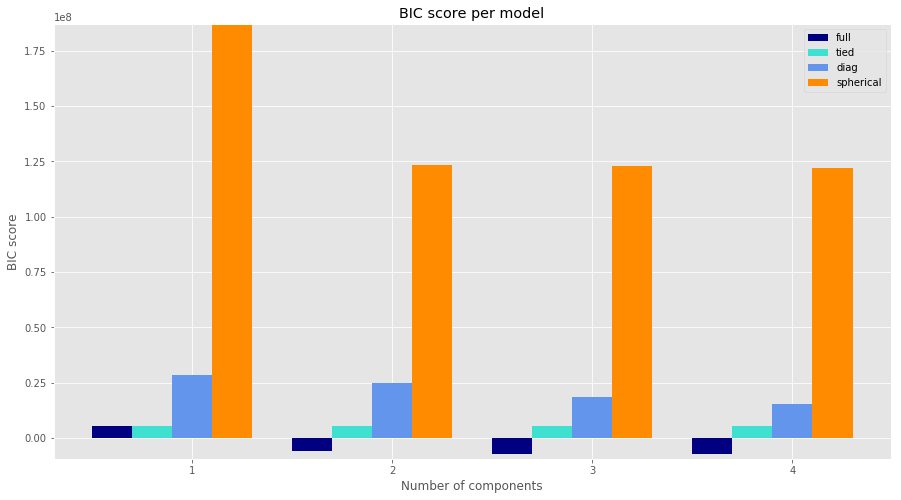

In [6]:
bic_scores = GMM.bic_scores(dfs, max_n_components=4)
plot.features.gmm_bic_scores(bic_scores, max_n_components=4)

In [7]:
clf = GMM.GMM(n_components=4, covariance_type='full')
clf.fit(dfs)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=4, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

### Verification

In [8]:
# Compute the weighted log probabilities for each sample, 1-dim ndarray is returned
log_probs = clf.anomaly_scores(dfs)
display(pd.Series(log_probs).describe())
pct = np.percentile(log_probs, 1)
display("1pct percentile: %d" % pct)
# np.where returns an array with the element positions where the condition is true
idx = np.where((log_probs < pct))
anomaly_log_probs = log_probs[idx]

count    46090.000000
mean        80.922454
std         77.157239
min     -13059.094238
25%         67.584160
50%         76.344038
75%        111.263752
max        135.729809
dtype: float64

'1pct percentile: -77'

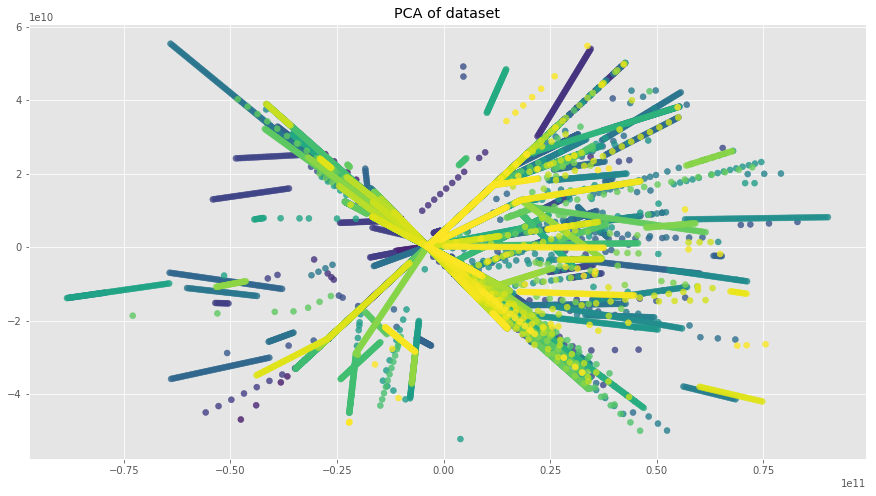

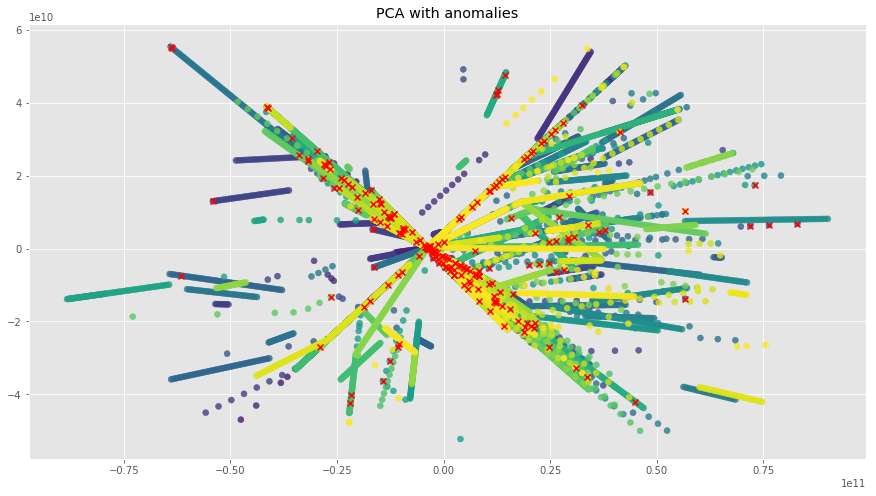

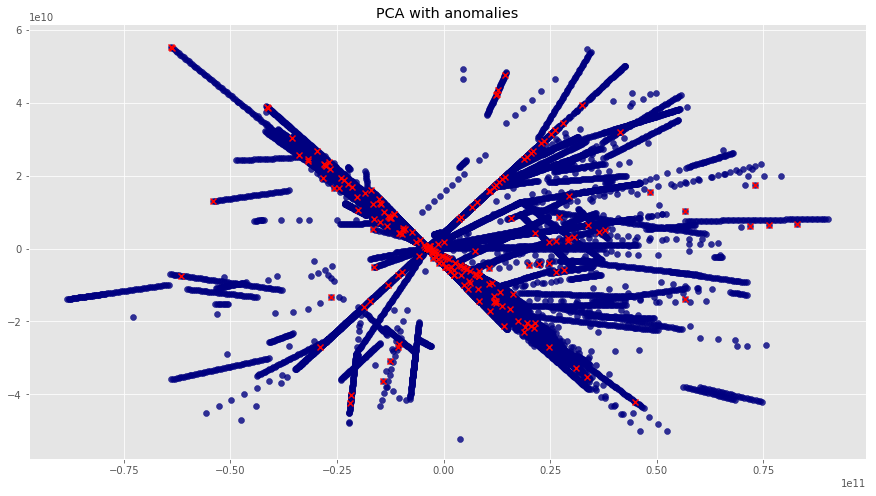

In [9]:
p = PCA.PCA(n_components=2)
p_data = p.transform(dfs)
plot.features.pca(p_data)
plot.anomalies.pca_anomalies(p_data, idx[0])
plot.anomalies.pca_anomalies(p_data, idx[0], color_coding=False)

The above figure shows how the points are distributed in time. The first point in time is blue, the last red.

In [10]:
top50 = np.argpartition(log_probs, 50) #first 50 elements will be the indexes of smallest elements
top50 = top50[:50]

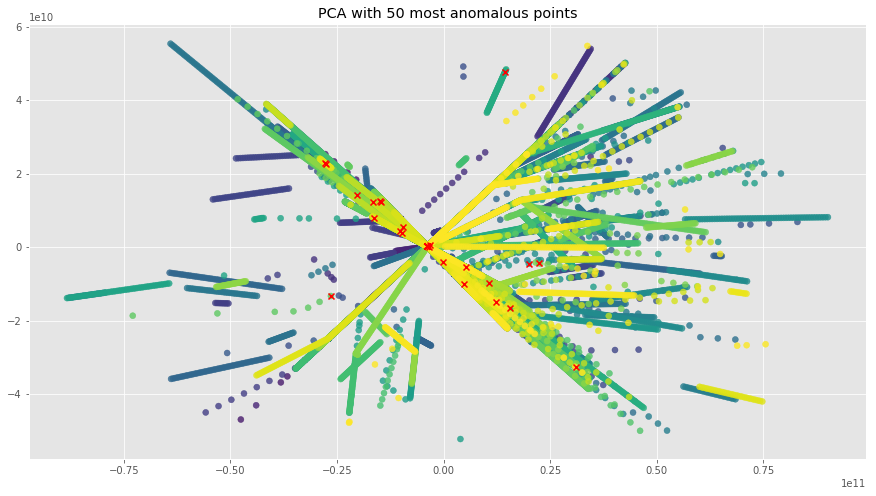

In [11]:
plot.anomalies.pca_anomalies(p_data, top50, "PCA with 50 most anomalous points")

In [12]:
anom = db.query_elogbook_anomalies()
# anom.drop("C0", axis=1, inplace=True)

Fetching data for pattern MKI.ELOGBOOK_tagged from 2016-04-16 00:00:00.000000 to 2016-09-14 00:00:00.000000
Fetching data for MKI.ELOGBOOK_tagged


In [13]:
anom.head()

C0            EVENTDATE EVENT_ID      PATH  \
2016-05-30 14:00:00  17  30/05/2016 16:00:00  2118913  LHC.MKI8   
2016-06-05 17:18:00  22  05/06/2016 19:18:00  2122744  LHC.MKI8   
2016-06-18 19:59:00  33  18/06/2016 21:59:00  2130953  LHC.MKI8   
2016-06-19 13:14:00  34  19/06/2016 15:14:00  2131267  LHC.MKI2   
2016-06-30 21:23:00  39  30/06/2016 23:23:00  2138252  LHC.MKI2   

                                                   SUBSTR_COMMENT_512_  \
2016-05-30 14:00:00  MKI.UA87.IPOC.AB2 Fall Time IQC check had been...   
2016-06-05 17:18:00  Thomas called me, following a call from the CC...   
2016-06-18 19:59:00  CCC called at 21:08 for a VAC INTERCONNECT int...   
2016-06-19 13:14:00  CCC called at 14h55 for a fault on MKI2.\nThe ...   
2016-06-30 21:23:00  Spark on MKI2B during SS at 51.2kV and 2.8us\n...   

                         TAG                    USERNAME VALUE  
2016-05-30 14:00:00  anomaly         mike.barnes@cern.ch  MKI8  
2016-06-05 17:18:00  anomaly         mike.barnes@cern.ch  MKI8  
2016-06-18 19:59:00  anomaly  christophe.lolliot@cern.ch  MKI8  
2016-06-19 13:14:00  anomaly  christophe.lolliot@cern.ch  MKI2  
2016-06-30 21:23:00  anomaly         mike.barnes@cern.ch  MKI2

In [14]:
dfs.iloc[top50.tolist()].head()

MKI.UA23.IPOC.CB1:T_LENGTH  MKI.UA23.IPOC.AB1:T_LENGTH  \
2016-08-02 22:52:20                   -0.010532                   -0.003494   
2016-06-20 00:33:04                   50.971370                   56.313951   
2016-07-31 01:26:37                    2.668018                    2.657266   
2016-07-29 10:03:16                   56.911895                   56.948299   
2016-08-02 18:55:01                   -0.006854                   -0.003078   

                     MKI.UA23.IPOC.AB1:E_KICK  MKI.UA23.IPOC.DB1:E_KICK  \
2016-08-02 22:52:20                  0.710525                  0.710531   
2016-06-20 00:33:04                 -0.515076                 -0.515126   
2016-07-31 01:26:37                  0.484924                  0.484874   
2016-07-29 10:03:16                 -0.515076                 -0.515126   
2016-08-02 18:55:01                 -0.522733                 -0.522731   

                     MKI.UA23.IPOC.AB1:T_FALLTIME  \
2016-08-02 22:52:20                      0.828571   
2016-06-20 00:33:04                   -132.657143   
2016-07-31 01:26:37                      1.104762   
2016-07-29 10:03:16                   -132.733333   
2016-08-02 18:55:01                      0.790476   

                     MKI.UA23.IPOC.DB1:T_FALLTIME  \
2016-08-02 22:52:20                      0.403846   
2016-06-20 00:33:04                   -133.144231   
2016-07-31 01:26:37                      1.778846   
2016-07-29 10:03:16                   -133.144231   
2016-08-02 18:55:01                      0.471154   

                     MKI.UA23.IPOC.AB1:T_START_TH  MKI.UA23.IPOC.CB1:E_KICK  \
2016-08-02 22:52:20                           1.0                  0.710531   
2016-06-20 00:33:04                      -13203.8                 -0.515126   
2016-07-31 01:26:37                           0.4                  0.484874   
2016-07-29 10:03:16                      -13209.8                 -0.515126   
2016-08-02 18:55:01                           0.4                 -0.522731   

                     MKI.UA23.IPOC.CB1:I_STRENGTH  \
2016-08-02 22:52:20                     -5.158167   
2016-06-20 00:33:04                     -0.002182   
2016-07-31 01:26:37                      0.694028   
2016-07-29 10:03:16                     -0.042542   
2016-08-02 18:55:01                     -3.835560   

                     MKI.UA23.IPOC.BB1:T_RISETIME  \
2016-08-02 22:52:20                      0.098039   
2016-06-20 00:33:04                  -2740.470588   
2016-07-31 01:26:37                      1.627451   
2016-07-29 10:03:16                   -129.450980   
2016-08-02 18:55:01                      0.000000   

                                        ...                      \
2016-08-02 22:52:20                     ...                       
2016-06-20 00:33:04                     ...                       
2016-07-31 01:26:37                     ...                       
2016-07-29 10:03:16                     ...                       
2016-08-02 18:55:01                     ...                       

                     MKI.B5L2.B1:TEMP_TUBE_UP:SW_SUM_1800_s  \
2016-08-02 22:52:20                               -0.215537   
2016-06-20 00:33:04                                0.982157   
2016-07-31 01:26:37                               -0.062465   
2016-07-29 10:03:16                               -0.534653   
2016-08-02 18:55:01                               -0.035070   

                     MKI.A5L2.B1:TEMP_TUBE_UP:SW_SUM_1800_s  \
2016-08-02 22:52:20                               -0.182742   
2016-06-20 00:33:04                                0.759013   
2016-07-31 01:26:37                                0.114090   
2016-07-29 10:03:16                               -0.390966   
2016-08-02 18:55:01                               -0.049146   

                     MKI.D5L2.B1:TEMP_TUBE_DOWN:SW_SUM_1800_s  \
2016-08-02 22:52:20                                 -0.258020   
2016-06-20 00:33:04                                  

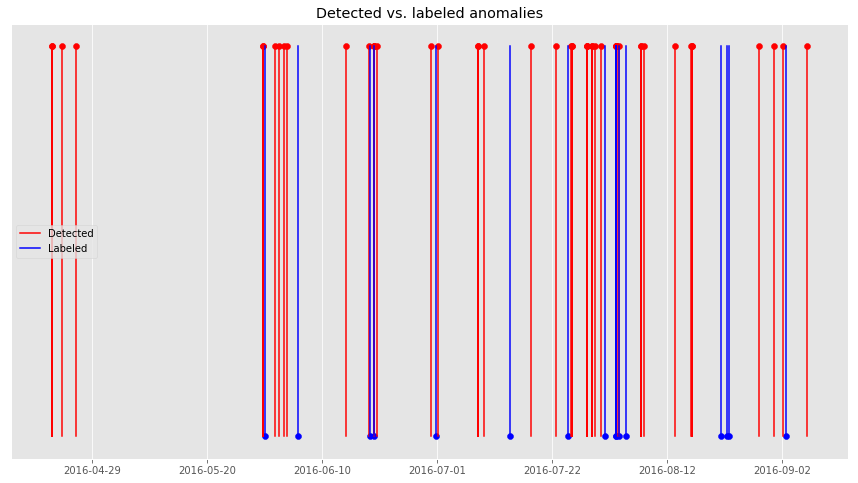

In [21]:
plot.anomalies.labeled_vs_detected(anom, dfs.iloc[top50.tolist()])

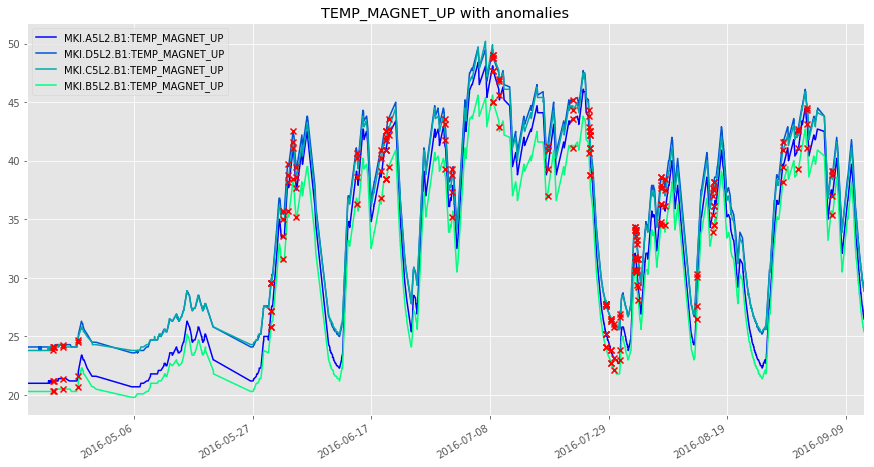

In [22]:
plot.anomalies.timeseries_anomalies(df, "TEMP_MAGNET_UP", top50)